In [1]:
# https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/
# https://physicscourses.colorado.edu/phys2210/phys2210_fa20/lecture/lec36-damped-oscillator/
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

(500, 1) (500, 1)
(10, 1) (10, 1)


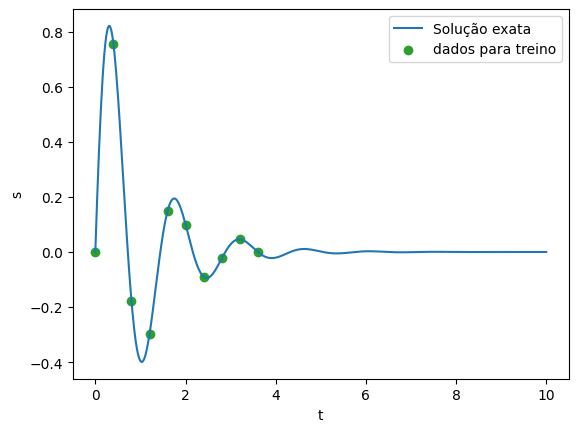

In [2]:

# EDO: 1*d2s/dt2+2*ds/dt+20*s=0 where s(0)=0 and s'(0)=5

# essa função calcula o oscilador de forma exata.

def solucao_exata(t):
    y=5*(1/np.sqrt(19))*np.exp(-t)*np.sin(np.sqrt(19)*t) #calculado no wolframalpha
    return y

# obtem a solução e pega alguns pontos para usar de treinamento
x = tf.linspace(0,10,500) # x nestes problema é o tempo
x = tf.cast(x, tf.float32)
x = tf.expand_dims(x, 1)

y = solucao_exata(x) # y neste caso é o s, a posição
print(x.shape, y.shape)

# dados para treinar a rede
#uma amostra a cada 20 pontos até o 200
x_data = x[0:200:20]
y_data = y[0:200:20]
#mostra os tamanhos das matrizes
print(x_data.shape, y_data.shape)

#mostra a solução subamortecida e os pontos escolhidos para treinar
plt.figure()
plt.plot(x, y, label="Solução exata")
plt.scatter(x_data, y_data, color="tab:green", label="dados para treino")
plt.xlabel('t')
plt.ylabel('s')
plt.legend()
plt.show()


Model: "rede_para_PINN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                64        
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1153 (4.50 KB)
Trainable params: 1153 (4.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Epoch 500/30000, Loss: 0.064462810754776, Data Loss: 0.06416671723127365, Physics Loss: 0.00029609486227855086
Epoch 1000/30000, Loss: 0.06363657116889954, Data Loss: 0.0634777694940567, Physics Loss: 0.00015879874990787357
Epoch 1500/30000, Loss: 0.06307441741228104, Data Loss: 0.06294577568769455, Physics Loss: 0.00012864178279414773
Epoch 2000/30000, Loss: 0.06062214821577072, Data Loss: 0.060469888150691986, Physics Loss: 0.00015225955576170236
Epoch 2500/30000, Loss: 0.018601220101118088, Data Loss: 0.018425144255161285, Physics Loss: 0.0001760758168529719
Epoch 3000/30000, Loss: 0.006928085815161467, Data Loss: 0.006668513175100088, Physics Loss: 0.00025957252364605665
Epoch 3500/30000, Loss: 0.004461412318050861, Data Loss: 0.004197945352643728, Physics Loss: 0.00026346693630330265
Epoch 4000/30000, Loss: 0.0014365428360179067, Data Loss: 0.000937964185141027, Physics Loss: 0.0004985786508768797
Epoch 4500/30000, Loss: 0.0005140387220308185, Data Loss: 0.00033615707070566714, Ph

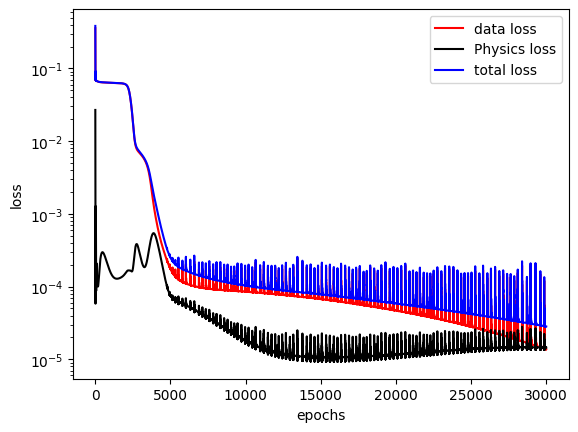

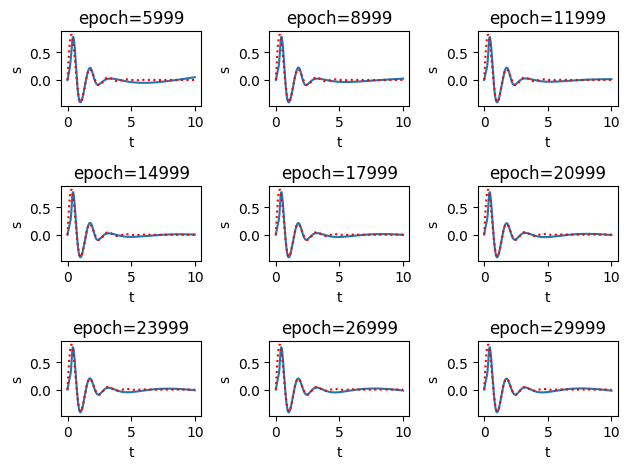

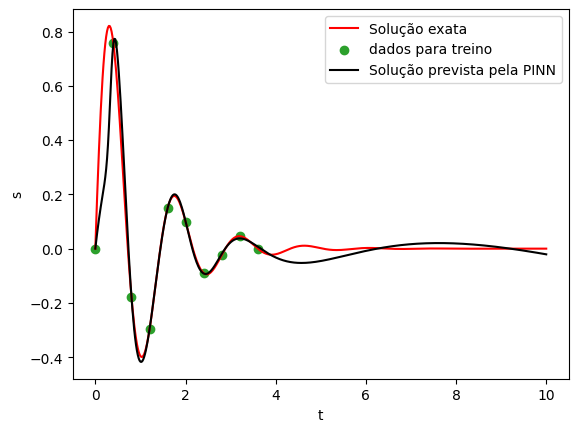

In [3]:
# implenta uma PINN
# na PINN, o loss combina o o ajuste dos pontos e satisfazer a EDO
# cálculo do gradiente é o desafio aqui: usando o API chamado Gradient Tape
#https://medium.com/codex/how-to-compute-gradients-in-tensorflow-and-pytorch-59a585752fb2
#SEM BATCH SIZE

start_time = time.time()

# x da EDO, com 30 pontos
x_phys = tf.linspace(0,10,30)
x_phys = tf.cast(x_phys, tf.float32)
x_phys = tf.expand_dims(x_phys, 1)

#hiperparametros
tf.random.set_seed(5) #fixa a semente para cada teste ser igual
learning_rate = 0.0005
epochs = 30000 #uns 780 seg no colab
k_phy_loss=(1e-4) # coloque zero nesta grandeza para uma FF!

# Arquiteruta do modelo neural, usando o keras
input_dim = 1
hidden_dim = 32
hidden_dim2 = 32
output_dim = 1

model_keras=tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_dim, input_dim=input_dim, use_bias=1,activation='tanh'),
    tf.keras.layers.Dense(hidden_dim2, activation='tanh'),
    tf.keras.layers.Dense(output_dim, activation='linear')
],name='rede_para_PINN')
print(model_keras.summary())

optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
# Treina a rede:
continuos_y_pred=np.zeros((len(x),10))
continuos_epoch=np.zeros((10,1))
count=0
h_loss=[]
h_data_loss=[]
h_Phys_loss=[]
for epoch in range(epochs):
    batch_X = x_data
    batch_y = tf.convert_to_tensor(y_data.astype('float32'))
    with tf.GradientTape() as tape:
        yh = model_keras(batch_X) #calcula as saidas da rede nos pontos "experimentais"
        data_loss = tf.reduce_mean(tf.square(yh - batch_y))
        with tf.GradientTape() as t2:
          t2.watch(x_phys)
          with tf.GradientTape() as t1:
            t1.watch(x_phys)
            yhp = model_keras(x_phys) #calcula as saidas da rede nos pontos escolhidos para ajustar a EDO
          dx  = t1.gradient(yhp, x_phys)# calcula dy/dx que é igual a ds/dt
        dx2 = t2.gradient(dx, x_phys) # calcula d^2y/dx^2 que é igual a d^2s/dt^2
        # EDO: 1*d2s/dt2+2*ds/dt+20*s=0 where s(0)=0 and s'(0)=1
        physics = 1*dx2 + 2*dx + 20*yhp
        Phys_loss=k_phy_loss*tf.reduce_mean(tf.square(physics))
        #loss = tf.math.exp(tf.math.log(Phys_loss) + tf.math.log(data_loss))
        loss = Phys_loss + data_loss
    gradients = tape.gradient(loss, model_keras.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_keras.trainable_variables))
    h_loss.append(loss)
    h_data_loss.append(data_loss)
    h_Phys_loss.append(Phys_loss)
    if ((epoch+1)%500==0):
      print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.numpy()}, Data Loss: {data_loss.numpy()}, Physics Loss: {Phys_loss.numpy()}")
      if ((epoch+1)%(np.round(epochs/10))==0):
        temp_pred=model_keras(x)
        yh = model_keras(x)
        continuos_y_pred[:,count]=temp_pred[:,0]
        continuos_epoch[count]=epoch
        count=count+1
        #plot_result(x,y,x_data,y_data,yh)
print("--- %s seconds ---" % (time.time() - start_time))

plt.figure()
plt.plot(h_data_loss,'r',label='data loss');
plt.plot(h_Phys_loss,'k',label='Physics loss');
plt.plot(h_loss,'b',label='total loss');
plt.yscale('log')
plt.legend()
plt.xlabel('epochs');plt.ylabel('loss')

plt.figure()
for qq in range(0,9):
  plt.subplot(3,3,qq+1)
  plt.plot(x,continuos_y_pred[:,qq+1])
  plt.plot(x,y,'r:')
  plt.xlabel('t');plt.ylabel('s')
  plt.title('epoch='+str(int(continuos_epoch[qq+1,0])))
plt.tight_layout()

plt.figure()
plt.plot(x, y,'r', label="Solução exata")
plt.scatter(x_data, y_data, color="tab:green", label="dados para treino")
plt.plot(x,continuos_y_pred[:,-1],'k', label="Solução prevista pela PINN")
plt.xlabel('t');plt.ylabel('s')
plt.legend()
